In [4]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pickle
import string
from tqdm import tqdm
spacy.require_gpu()

nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "ner"])
nlp.max_length = 3_000_000 # needed for long documents, otherwise spaCy cannot handle that many tokens

nlp.disable_pipe("parser")
nlp.enable_pipe("senter")

# IMPORTANT NOTE: THESE STATS ARE ONLY FOR THE TESTING DATASET; THE ORIGINAL AUTHORS DID SOME STATS AS WELL BUT ON THE ENTIRE DATASET
multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")
eurlexsum = load_dataset("dennlinger/eur-lex-sum", "english")

In [2]:
nlp.pipe_names

['tagger', 'senter', 'attribute_ruler', 'lemmatizer']

Compute average number of documents per docket per dataset split

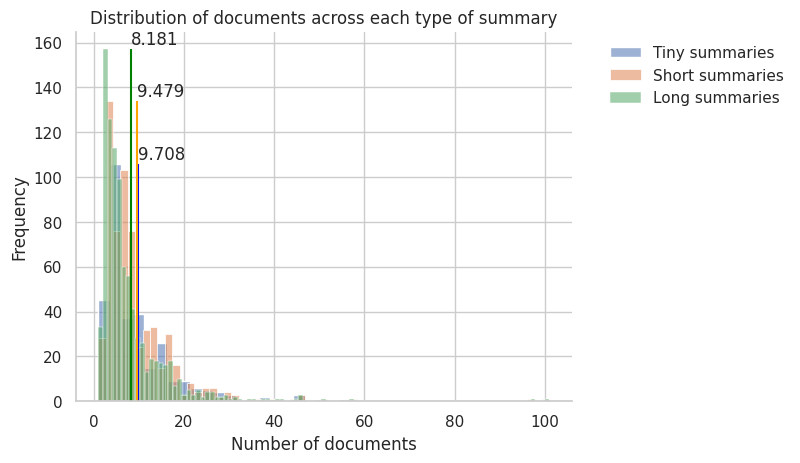

In [3]:
def make_plot(data, title):
    color_vline = {
        "tiny": "blue",
        "short": "orange", 
        "long": "green",
        "all": "red"
    }
    fig = sns.histplot(data, alpha=0.55, label=title.title() + " " + "summaries")
    
    bin_heights = [patch.get_height() for patch in fig.patches]

    plt.vlines(x=[np.mean(data)], ymin=[0], ymax=[np.max(bin_heights)], colors=[color_vline[title]])
    plt.text(x=np.mean(data), y=np.max(bin_heights)+2, s=f"{np.mean(data):.3f}")

    sns.despine()
    plt.title("Distribution of documents across each type of summary")
    plt.xlabel("Number of documents")
    plt.ylabel("Frequency")
    return fig

summ_types = ["tiny", "short", "long"]

sns.set_theme(style="whitegrid")
for summ in summ_types:
    if summ != "all":
        aux_data = multi_lexsum["test"].filter(lambda x: x[f"summary/{summ}"] != None)
    else:
        aux_data = multi_lexsum["test"]
    aux_len = [len(d) for d in aux_data["sources"]]
    make_plot(aux_len, summ)
    # plt.show()

plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")

In [6]:
import torch

punctuation = set(string.punctuation) | set(["\n"])
def count_spacy(docket):
    aux = nlp.pipe(docket, batch_size=1)
    words = 0
    sents = 0

    for doc in aux:
        sents += len(list(doc.sents))
        words += sum([1 for word in doc if word.text not in punctuation])
        torch.cuda.empty_cache()

    return words, sents

In [8]:
summ_types = ["tiny", "short", "long"]
stats_summ_multilex = {}
for summ in summ_types:
    aux_data = multi_lexsum["test"].filter(lambda x: x[f"summary/{summ}"] != None)
 
    aux_count = np.asarray([count_spacy(docket) for docket in tqdm(aux_data["sources"])])
    stats_summ_multilex[summ] = aux_count

pickle.dump(stats_summ_multilex, open("stats_summ_multilex.pickle", "wb"))

Filter:   0%|          | 0/908 [00:00<?, ? examples/s]

100%|██████████| 312/312 [09:49<00:00,  1.89s/it]


Filter:   0%|          | 0/908 [00:00<?, ? examples/s]

100%|██████████| 616/616 [16:45<00:00,  1.63s/it]


Filter:   0%|          | 0/908 [00:00<?, ? examples/s]

100%|██████████| 908/908 [18:01<00:00,  1.19s/it]


In [7]:
summ_types = ["test", "validation"]
stats_summ_eurlex = {}
for summ in summ_types:
    aux_data = eurlexsum[summ]
    aux_count = np.asarray([count_spacy([docket]) for docket in tqdm(aux_data["reference"])])
    stats_summ_eurlex[summ] = aux_count

pickle.dump(stats_summ_eurlex, open("stats_summ_eurlex.pickle", "wb"))

100%|██████████| 187/187 [01:31<00:00,  2.05it/s]


In [7]:
print(np.mean(stats_summ_eurlex["test"], axis=0))
print(np.mean(stats_summ_eurlex["validation"], axis=0))

[19336.64361702   528.95744681]
[19158.40106952   515.04278075]


In [9]:
print(np.mean(stats_summ_multilex["tiny"], axis=0))
print(np.mean(stats_summ_multilex["short"], axis=0))
print(np.mean(stats_summ_multilex["long"], axis=0))

[84049.54487179  3032.40705128]
[76876.64448052  2719.8961039 ]
[57333.36784141  2032.01431718]
